# <Center> Homework 5: Classification </center>

This assignment needs the following two data files:
- train.csv: dataset for training
- test.csv: dataset for testing. 
    
Both of them have samples in the following format. The `text` column contains documents and the `label` column gives the sentiment of each document.

|label | text |
|------|------|
|1|  I must admit that I'm addicted to "Version 2.0...|
|0|  I think it's such a shame that an enormous tal...|
|1|  The Sunsout No Room at The Inn Puzzle has oddl...|
|...|...|


## Q1 Classification

- Define a function `create_model(train_docs, train_y, test_docs, test_y, model_type='svm', stop_words='english', min_df = 1, print_result = True, algorithm_para=1.0`), where

    - `train_docs`: is a list of documents for training
    - `train_y`: is the ground-truth labels of training documents
    - `test_docs`: is a list of documents for test
    - `test_y`: is the ground-truth labels of test documents
    - `model_type`: two options: `nb` (Multinomial Naive Bayes) or `svm` (Linear SVM)
    - `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
    - `min_df`: only word with document frequency above this threshold can be included. The default is 1. 
    - `print_result`: controls whether to show classification report or plots. The default is True.
    - `algorithm_para`: the hyperparameter of algorithms, refers to C in SVM and alpha in NB. Both C and alpha have default values of 1.0. Please check sklearn documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


- This function does the following:
    - Fit a `TfidfVectorizer` using `train_docs` with options `stop_words, min_df` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
    - Build `linear SVM` or `Multinomial Naive Bayes` model as specified by `model_type` with `algorithm_para` setting. Train the model using the extracted features and `train_y`. 
    - Transform `test_docs` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`).
    - Predict the labels for `test_docs`. If `print_result` is True, print the classification report.
    - Calculate the AUC score and PRC score (or Average Precision) for class 1 on the test dataset. If `print_result` is True, plot the ROC and PRC curves. **Hint**: 
        - `sklearn.svm.LinearSVM` does not provide `predict_proba` function. 
        - Instead, you can use its `decision_function` (see <a href = "https://stackoverflow.com/questions/59227176/how-to-plot-roc-and-calculate-auc-for-binary-classifier-with-no-probabilities-s">some referenc code</a>) 
        - Another option is to use `sklearn.svm.SVC` with `kernel='linear' and probability=False` (see <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html"> reference</a>)
    - Return the AUC and PRC scores.

    
- Test your function with following cases:
    - model_type='svm', stop_words = 'english', min_df = 1
    - model_type='nb', stop_words = 'english', min_df = 1

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm 
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

train = pd.read_csv("train5.csv")
test = pd.read_csv("test5.csv")


In [4]:
# Define the function for Task 1

def create_model(train_docs, train_y, test_docs, test_y, \
              model_type='svm', stop_words=None, min_df = 1, print_result = True, algorithm_para=1.0):
    
    
    auc_score,prc_score=0.0,0.0

    # Fit TfidfVectorizer with stop words and min_df.
    tfidf_vect = TfidfVectorizer(stop_words=stop_words,min_df=min_df)
    X_train = tfidf_vect.fit_transform(train_docs)

    # Build model.
    if model_type=='nb':
        clf = MultinomialNB(alpha=algorithm_para)
    elif model_type=='svm':
        clf = svm.LinearSVC(C=algorithm_para)
    clf.fit(X_train, train_y)

    # Predict labels.
    X_test = tfidf_vect.transform(test_docs)
    pred_y = clf.predict(X_test)

    # Calculate AUC and PRC scores.
    if model_type=='nb':
        pred_p = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(test_y, pred_p[:,1], pos_label=1)
        prec, rec, thresh = precision_recall_curve(test_y,pred_p[:,1],pos_label=1)
        auc_score = auc(fpr, tpr)
        prc_score = auc(rec, prec)
    elif model_type=='svm':
        pred_p = clf.decision_function(X_test)
        fpr, tpr, thresholds = roc_curve(test_y, pred_p, pos_label=1)
        prec, rec, thresh = precision_recall_curve(test_y,pred_p,pos_label=1)
        auc_score = auc(fpr, tpr)
        prc_score = auc(rec, prec)

        
    # Print classification report and plot roc,prc curves.
    if print_result:

        # Classification Report
        print(classification_report(test_y,pred_y,target_names=['0','1']))
        
        # AUC and PRC scores
        print("AUC: {:.2%}".format(auc_score)+" PRC: {:.2%}".format(prc_score))

        # Plot ROC Curve
        plt.figure();
        plt.plot(fpr, tpr, color='darkorange', lw=2);
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('False Positive Rate');
        plt.ylabel('True Positive Rate');
        plt.title(model_type+'-AUC');
        plt.show();

        # Plot PRC Curve
        plt.figure();
        plt.plot(rec, prec, color='darkorange', lw=2);
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title(model_type+'-PRC');
        plt.show();

    return auc_score, prc_score

    

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       509
           1       0.82      0.84      0.83       491

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000

AUC: 91.50% PRC: 91.59%


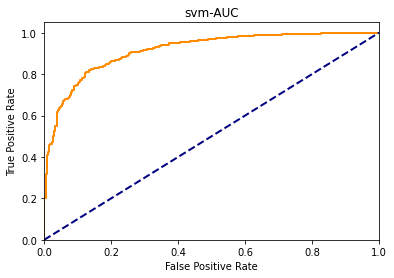

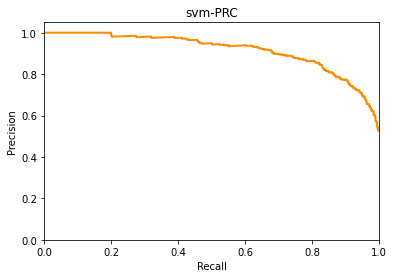

In [5]:
# Test the function with 'svm'

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
          model_type='svm', stop_words = 'english', min_df = 1, print_result=True, algorithm_para=1.0)


              precision    recall  f1-score   support

           0       0.82      0.77      0.80       509
           1       0.78      0.83      0.80       491

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000

AUC: 88.87% PRC: 89.49%


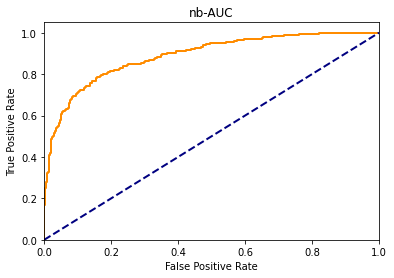

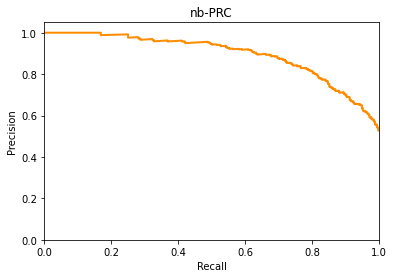

In [6]:
# Test the function with 'nb' 

auc_score, prc_score = create_model(train["text"], train["label"], test["text"], test["label"], \
                    model_type='nb', stop_words = 'english', min_df = 1, print_result=True, algorithm_para=1.0)

### Task 2: Search for best parameters 

From Task 1, you may find there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters

- Define a function `search_para(docs, y)` where `docs` are training documents and `y` is the ground-truth labels.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and `SVM` classifier 
    - Define the parameter ranges as follow:
        - `stop_words': [None, 'english']`
        - `min_df: [1,2,5]`
        - `C: [0.2,0.5,0.8]`
    - Set the scoring metric to "f1_macro"
    - Use `GridSearchCV` with `5-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the best parameter values
    
- Call the function `svm_model` defined in Task 1 `with the best parameter values`. You will have to add the best C value to the original function, because you used default settings of the SVM classifier previously. Then please briefly answer the following:
    - Compare with the model in Task 1, how is the performance improved on the test dataset?
    - Why do you think the new parameter values help sentiment classification?

In [7]:
# Define grade search function

def search_para(docs, y):
    # Create Pipeline
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),('clf', svm.LinearSVC())])
    # Initialize parameters
    parameters = {'tfidf__stop_words':[None,"english"],'tfidf__min_df':[1, 2,5],'clf__C': [0.2,0.5,0.8],}
    # Set scoring metric
    metric =  "f1_macro"
    # Run GridSearch
    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring=metric, cv=5)
    gs_clf = gs_clf.fit(docs, y)
    # Print best parameter values
    for param_name in gs_clf.best_params_:
        print("{0}:\t{1}".format(param_name,gs_clf.best_params_[param_name]))
      

In [8]:
search_para(train["text"], train["label"])

clf__C:	0.2
tfidf__min_df:	2
tfidf__stop_words:	None


              precision    recall  f1-score   support

           0       0.84      0.86      0.85       509
           1       0.85      0.84      0.84       491

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

AUC: 92.42% PRC: 92.30%


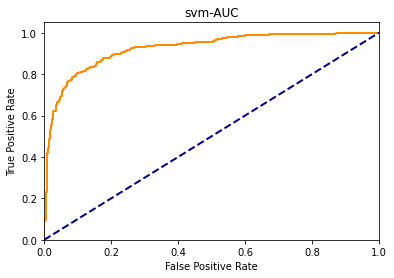

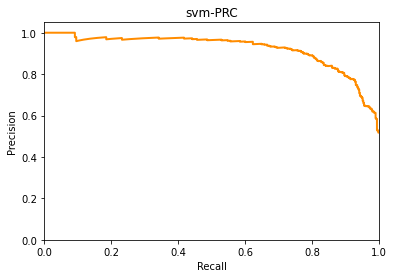

In [9]:
# call the function with the best parameters

auc_score, prc_score = create_model(train["text"], train["label"], test["text"], test["label"], \
          model_type='svm', stop_words = None, min_df = 2, print_result=True, algorithm_para=0.2)

# Please answer the questions
# 1. model 1-> AUC: 91.50% PRC: 91.59%     model 2-> AUC: 92.42% PRC: 92.30%
#    Since the AUC and PRC scores are more the output suggests that model 2 performs
#    better than model 1, but since improvement is less than 1%, we can't say the 
#    new model performs significantly better than the previous one if the scale of
#    the data is small, however a larger dataset may give out significant differences.
# 2. The new parameter values likely provide more information to the model
#    for eg. min_df 2 will incline the model towards more important words 
#    ignoring words occuring only once, which may or may not be necessarily
#    important to the document, a low value of C also changes the regularization
#    boundary which sets a more strict scope for misclassifications as is needed
#    in case of sentiment classification, in any case the gridsearch exhaustively
#    iterates through all given combinations so we can see in this case stop-words
#    carry more useful information.

## Task 3. How many samples are enough? 

This task is to help you understand the impact of sample size on classifier performance. 

- Define a function `sample_size_impact(train_docs, train_y, test_docs, test_y)` with the input as defined above. 
    
    
- This function does the following:
    - Starting with 500 samples, in each round you build a classifier with 500 more samples. i.e. in round 1, you use samples from 0:500, and in round 2, you use samples from 0:1000, …, until you use all samples. 
    - In each round, call the `create_model` function with `model_type='svm'` and then `model_type='nb'`. Keep other parameters as default. Record the AUC score of each model type and the sample size.
    - For each model type, plot a line chart show the relationship between sample size and the AUC score. 
    - This function has no return.
    
    
- Write your analysis on the following:
    - How sample size affects each classifier’s performance? 
    - If it is expensive to collect and label samples, can you decide an optimal sample size with model performance and the cost of samples both considered? 
    - How is performance of SVM classifier compared with Naïve Bayes classifier?

In [10]:
# Show the impact of sample size

def sample_size_impact(train_docs, train_y, test_docs, test_y):
    i=0
    # Declare empty list to store AUC and sample_size values
    svm_auc_list = list()
    nb_auc_list = list()
    sample_size = list()
    # Calculate AUC for all smaple sizes for both models
    while i<len(train_y):
      if(i+500<len(train_y)):
        i=i+500
      else:
        i=len(train_y)
      auc_svm, prc_svm = create_model(train_docs[0:i], train_y[0:i], test_docs, test_y, \
          model_type='svm', stop_words = 'english', min_df = 1, print_result=False, algorithm_para=1.0)
      auc_nb, prc_nb = create_model(train_docs[0:i], train_y[0:i], test_docs, test_y, \
          model_type='nb', stop_words = 'english', min_df = 1, print_result=False, algorithm_para=1.0)
      sample_size.append(i+1)
      svm_auc_list.append(auc_svm)
      nb_auc_list.append(auc_nb)
      
    # Plot AUC vs Sample Size
    plt.figure();
    plt.plot(sample_size, svm_auc_list, color='darkorange', lw=2, label = 'SVM');
    plt.plot(sample_size, nb_auc_list, color='navy', lw=2, label = 'NB');
    plt.legend()
    plt.xlabel('Sample Size');
    plt.ylabel('AUC');
    plt.show();

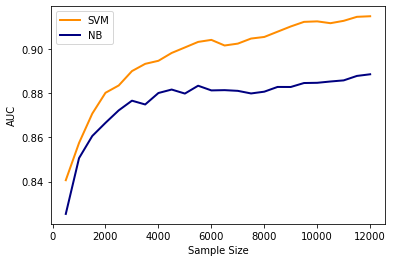

In [11]:
# Test the function

sample_size_impact(train["text"], train["label"], test["text"], test["label"])


# Briefly answer the questions
# 1. We can see that as the train sample size increases the AUC increases,
#    suggesting a large train set results in a better perfirming model, however
#    the rate of improvement flattens out at a certain point so we dont need
#    a too large train set to avoid computational increase and risk of overfitting.
# 2. a sample size of around 5500-6000 can be considered to reduce cost of samples
#    as there is not much significant change in the model performance(~1%) when 
#    increasing sample size after that.
# 3. the SVM classifier performs significantly better than Naive Bais classifier,
#    at larger sample sizes.

## Task 4 (Bonus): How to improve sentiment classification?

- Can you tune other parameters of TfidfVectorizer or SVM model to further improve the classification performance? Try to beat the model you get in Task 2!

In [12]:
# We can do things like define our own tokenizer after better understanding 
# the document and adjust the other parameters too.
# for now i have used grid search to obtain following parameters 
# to beat the current model

In [13]:
tfidf_vect = TfidfVectorizer(stop_words=None,min_df=1,analyzer='word')
X_train = tfidf_vect.fit_transform(train["text"])
clf = svm.LinearSVC(C=0.25,class_weight='balanced')
clf.fit(X_train, train["label"])
X_test = tfidf_vect.transform(test["text"])
pred_y = clf.predict(X_test)
pred_p = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(test["label"], pred_p, pos_label=1)
prec, rec, thresh = precision_recall_curve(test["label"],pred_p,pos_label=1)
auc_score = auc(fpr, tpr)
prc_score = auc(rec, prec)
print("AUC: {:.2%}".format(auc_score)+" PRC: {:.2%}".format(prc_score))


AUC: 92.45% PRC: 92.52%
